In [17]:
import json

import pandas as pd
import requests

from requests.adapters import HTTPAdapter
from requests.packages.urllib3.util.retry import Retry
from requests import status_codes

from pytrends import exceptions

from urllib.parse import quote

BASE_TRENDS_URL = 'https://trends.google.com/trends'


class TrendReq(object):
    """
    Google Trends API
    """
    GET_METHOD = 'get'
    POST_METHOD = 'post'
    GENERAL_URL = f'{BASE_TRENDS_URL}/api/explore'
    INTEREST_OVER_TIME_URL = f'{BASE_TRENDS_URL}/api/widgetdata/multiline'
    MULTIRANGE_INTEREST_OVER_TIME_URL = f'{BASE_TRENDS_URL}/api/widgetdata/multirange'
    INTEREST_BY_REGION_URL = f'{BASE_TRENDS_URL}/api/widgetdata/comparedgeo'
    RELATED_QUERIES_URL = f'{BASE_TRENDS_URL}/api/widgetdata/relatedsearches'
    TRENDING_SEARCHES_URL = f'{BASE_TRENDS_URL}/hottrends/visualize/internal/data'
    TOP_CHARTS_URL = f'{BASE_TRENDS_URL}/api/topcharts'
    SUGGESTIONS_URL = f'{BASE_TRENDS_URL}/api/autocomplete/'
    CATEGORIES_URL = f'{BASE_TRENDS_URL}/api/explore/pickers/category'
    TODAY_SEARCHES_URL = f'{BASE_TRENDS_URL}/api/dailytrends'
    REALTIME_TRENDING_SEARCHES_URL = f'{BASE_TRENDS_URL}/api/realtimetrends'
    ERROR_CODES = (500, 502, 504, 429)

    def __init__(self, hl='en-US', tz=360, geo='', timeout=(2, 5), proxies='',
                 retries=0, backoff_factor=0, requests_args=None):
        """
        Initialize default values for params
        """
        # google rate limit
        self.google_rl = 'You have reached your quota limit. Please try again later.'
        self.results = None
        # set user defined options used globally
        self.tz = tz
        self.hl = hl
        self.geo = geo
        self.kw_list = list()
        self.timeout = timeout
        self.proxies = proxies  # add a proxy option
        self.retries = retries
        self.backoff_factor = backoff_factor
        self.proxy_index = 0
        self.requests_args = requests_args or {}
        self.cookies = self.GetGoogleCookie()
        # intialize widget payloads
        self.token_payload = dict()
        self.interest_over_time_widget = dict()
        self.interest_by_region_widget = dict()
        self.related_topics_widget_list = list()
        self.related_queries_widget_list = list()

        self.headers = {'accept-language': self.hl}
        self.headers.update(self.requests_args.pop('headers', {}))
        
    def GetGoogleCookie(self):
        """
        Gets google cookie (used for each and every proxy; once on init otherwise)
        Removes proxy from the list on proxy error
        """
        while True:
            if "proxies" in self.requests_args:
                try:
                    return dict(filter(lambda i: i[0] == 'NID', requests.post(
                        f'{BASE_TRENDS_URL}/?geo={self.hl[-2:]}',
                        timeout=self.timeout,
                        **self.requests_args
                    ).cookies.items()))
                except:
                    continue
            else:
                if len(self.proxies) > 0:
                    proxy = {'https': self.proxies[self.proxy_index]}
                else:
                    proxy = ''
                try:
                    return dict(filter(lambda i: i[0] == 'NID', requests.post(
                        f'{BASE_TRENDS_URL}/?geo={self.hl[-2:]}',
                        timeout=self.timeout,
                        proxies=proxy,
                        **self.requests_args
                    ).cookies.items()))
                except requests.exceptions.ProxyError:
                    print('Proxy error. Changing IP')
                    if len(self.proxies) > 1:
                        self.proxies.remove(self.proxies[self.proxy_index])
                    else:
                        print('No more proxies available. Bye!')
                        raise
                    continue

    def GetNewProxy(self):
        """
        Increment proxy INDEX; zero on overflow
        """
        if self.proxy_index < (len(self.proxies) - 1):
            self.proxy_index += 1
        else:
            self.proxy_index = 0

    def _get_data(self, url, method=GET_METHOD, trim_chars=0, **kwargs):
        """Send a request to Google and return the JSON response as a Python object
        :param url: the url to which the request will be sent
        :param method: the HTTP method ('get' or 'post')
        :param trim_chars: how many characters should be trimmed off the beginning of the content of the response
            before this is passed to the JSON parser
        :param kwargs: any extra key arguments passed to the request builder (usually query parameters or data)
        :return:
        """
        s = requests.session()
        # Retries mechanism. Activated when one of statements >0 (best used for proxy)
        if self.retries > 0 or self.backoff_factor > 0:
            retry = Retry(total=self.retries, read=self.retries,
                          connect=self.retries,
                          backoff_factor=self.backoff_factor,
                          status_forcelist=TrendReq.ERROR_CODES,
                          allowed_methods=frozenset(['GET', 'POST']))
            s.mount('https://', HTTPAdapter(max_retries=retry))

        s.headers.update(self.headers)
        if len(self.proxies) > 0:
            self.cookies = self.GetGoogleCookie()
            s.proxies.update({'https': self.proxies[self.proxy_index]})
        if method == TrendReq.POST_METHOD:
            response = s.post(url, timeout=self.timeout,
                              cookies=self.cookies, **kwargs,
                              **self.requests_args)  # DO NOT USE retries or backoff_factor here
        else:
            response = s.get(url, timeout=self.timeout, cookies=self.cookies,
                             **kwargs, **self.requests_args)  # DO NOT USE retries or backoff_factor here
        # check if the response contains json and throw an exception otherwise
        # Google mostly sends 'application/json' in the Content-Type header,
        # but occasionally it sends 'application/javascript
        # and sometimes even 'text/javascript
        if response.status_code == 200 and 'application/json' in \
                response.headers['Content-Type'] or \
                'application/javascript' in response.headers['Content-Type'] or \
                'text/javascript' in response.headers['Content-Type']:
            # trim initial characters
            # some responses start with garbage characters, like ")]}',"
            # these have to be cleaned before being passed to the json parser
            content = response.text[trim_chars:]
            # parse json
            self.GetNewProxy()
            return json.loads(content)
        else:
            if response.status_code == status_codes.codes.too_many_requests:
                raise exceptions.TooManyRequestsError.from_response(response)
            raise exceptions.ResponseError.from_response(response)

    def build_payload(self, kw_list, cat=0, timeframe='today 5-y', geo='',
                      gprop=''):
        """Create the payload for related queries, interest over time and interest by region"""
        if gprop not in ['', 'images', 'news', 'youtube', 'froogle']:
            raise ValueError('gprop must be empty (to indicate web), images, news, youtube, or froogle')
        self.kw_list = kw_list
        self.geo = geo or self.geo
        self.token_payload = {
            'hl': self.hl,
            'tz': self.tz,
            'req': {'comparisonItem': [], 'category': cat, 'property': gprop}
        }

        # Check if timeframe is a list
        if isinstance(timeframe, list):
            for index, kw in enumerate(self.kw_list):
                keyword_payload = {'keyword': kw, 'time': timeframe[index], 'geo': self.geo}
                self.token_payload['req']['comparisonItem'].append(keyword_payload)
        else: 
            # build out json for each keyword with
            for kw in self.kw_list:
                keyword_payload = {'keyword': kw, 'time': timeframe, 'geo': self.geo}
                self.token_payload['req']['comparisonItem'].append(keyword_payload)

        # requests will mangle this if it is not a string
        self.token_payload['req'] = json.dumps(self.token_payload['req'])
        # get tokens
        self._tokens()
        return

    def _tokens(self):
        """Makes request to Google to get API tokens for interest over time, interest by region and related queries"""
        # make the request and parse the returned json
        widget_dicts = self._get_data(
            url=TrendReq.GENERAL_URL,
            method=TrendReq.GET_METHOD,
            params=self.token_payload,
            trim_chars=4,
        )['widgets']
        # order of the json matters...
        first_region_token = True
        # clear self.related_queries_widget_list and self.related_topics_widget_list
        # of old keywords'widgets
        self.related_queries_widget_list[:] = []
        self.related_topics_widget_list[:] = []
        # assign requests
        for widget in widget_dicts:
            if widget['id'] == 'TIMESERIES':
                self.interest_over_time_widget = widget
            if widget['id'] == 'GEO_MAP' and first_region_token:
                self.interest_by_region_widget = widget
                first_region_token = False
            # response for each term, put into a list
            if 'RELATED_TOPICS' in widget['id']:
                self.related_topics_widget_list.append(widget)
            if 'RELATED_QUERIES' in widget['id']:
                self.related_queries_widget_list.append(widget)
        return

    def interest_over_time(self):
        """Request data from Google's Interest Over Time section and return a dataframe"""

        over_time_payload = {
            # convert to string as requests will mangle
            'req': json.dumps(self.interest_over_time_widget['request']),
            'token': self.interest_over_time_widget['token'],
            'tz': self.tz
        }

        # make the request and parse the returned json
        req_json = self._get_data(
            url=TrendReq.INTEREST_OVER_TIME_URL,
            method=TrendReq.GET_METHOD,
            trim_chars=5,
            params=over_time_payload,
        )

        df = pd.DataFrame(req_json['default']['timelineData'])
        if (df.empty):
            return df

        df['date'] = pd.to_datetime(df['time'].astype(dtype='float64'),
                                    unit='s')
        df = df.set_index(['date']).sort_index()
        # split list columns into seperate ones, remove brackets and split on comma
        result_df = df['value'].apply(lambda x: pd.Series(
            str(x).replace('[', '').replace(']', '').split(',')))
        # rename each column with its search term, relying on order that google provides...
        for idx, kw in enumerate(self.kw_list):
            # there is currently a bug with assigning columns that may be
            # parsed as a date in pandas: use explicit insert column method
            result_df.insert(len(result_df.columns), kw,
                             result_df[idx].astype('int'))
            del result_df[idx]

        if 'isPartial' in df:
            # make other dataframe from isPartial key data
            # split list columns into seperate ones, remove brackets and split on comma
            df = df.fillna(False)
            result_df2 = df['isPartial'].apply(lambda x: pd.Series(
                str(x).replace('[', '').replace(']', '').split(',')))
            result_df2.columns = ['isPartial']
            # Change to a bool type.
            result_df2.isPartial = result_df2.isPartial == 'True'
            # concatenate the two dataframes
            final = pd.concat([result_df, result_df2], axis=1)
        else:
            final = result_df
            final['isPartial'] = False

        return final

    def multirange_interest_over_time(self):
        """Request data from Google's Interest Over Time section across different time ranges and return a dataframe"""

        over_time_payload = {
            # convert to string as requests will mangle
            'req': json.dumps(self.interest_over_time_widget['request']),
            'token': self.interest_over_time_widget['token'],
            'tz': self.tz
        }

        # make the request and parse the returned json
        req_json = self._get_data(
            url=TrendReq.MULTIRANGE_INTEREST_OVER_TIME_URL,
            method=TrendReq.GET_METHOD,
            trim_chars=5,
            params=over_time_payload,
        )

        df = pd.DataFrame(req_json['default']['timelineData'])
        if (df.empty):
            return df

        result_df = pd.json_normalize(df['columnData'])

        # Split dictionary columns into seperate ones
        for i, column in enumerate(result_df.columns):
            result_df["[" + str(i) + "] " + str(self.kw_list[i]) + " date"] = result_df[i].apply(pd.Series)["formattedTime"]
            result_df["[" + str(i) + "] " + str(self.kw_list[i]) + " value"] = result_df[i].apply(pd.Series)["value"]   
            result_df = result_df.drop([i], axis=1)
        
        # Adds a row with the averages at the top of the dataframe
        avg_row = {}
        for i, avg in enumerate(req_json['default']['averages']):
            avg_row["[" + str(i) + "] " + str(self.kw_list[i]) + " date"] = "Average"
            avg_row["[" + str(i) + "] " + str(self.kw_list[i]) + " value"] = req_json['default']['averages'][i]

        result_df.loc[-1] = avg_row
        result_df.index = result_df.index + 1
        result_df = result_df.sort_index()
        
        return result_df


    def interest_by_region(self, resolution='COUNTRY', inc_low_vol=False,
                           inc_geo_code=False):
        """Request data from Google's Interest by Region section and return a dataframe"""

        # make the request
        region_payload = dict()
        if self.geo == '':
            self.interest_by_region_widget['request'][
                'resolution'] = resolution
        elif self.geo == 'US' and resolution in ['DMA', 'CITY', 'REGION']:
            self.interest_by_region_widget['request'][
                'resolution'] = resolution

        self.interest_by_region_widget['request'][
            'includeLowSearchVolumeGeos'] = inc_low_vol

        # convert to string as requests will mangle
        region_payload['req'] = json.dumps(
            self.interest_by_region_widget['request'])
        region_payload['token'] = self.interest_by_region_widget['token']
        region_payload['tz'] = self.tz

        # parse returned json
        req_json = self._get_data(
            url=TrendReq.INTEREST_BY_REGION_URL,
            method=TrendReq.GET_METHOD,
            trim_chars=5,
            params=region_payload,
        )
        df = pd.DataFrame(req_json['default']['geoMapData'])
        if (df.empty):
            return df

        # rename the column with the search keyword
        geo_column = 'geoCode' if 'geoCode' in df.columns else 'coordinates'
        columns = ['geoName', geo_column, 'value']
        df = df[columns].set_index(['geoName']).sort_index()
        # split list columns into separate ones, remove brackets and split on comma
        result_df = df['value'].apply(lambda x: pd.Series(
            str(x).replace('[', '').replace(']', '').split(',')))
        if inc_geo_code:
            if geo_column in df.columns:
                result_df[geo_column] = df[geo_column]
            else:
                print('Could not find geo_code column; Skipping')

        # rename each column with its search term
        for idx, kw in enumerate(self.kw_list):
            result_df[kw] = result_df[idx].astype('int')
            del result_df[idx]

        return result_df

    def related_topics(self):
        """Request data from Google's Related Topics section and return a dictionary of dataframes
        If no top and/or rising related topics are found, the value for the key "top" and/or "rising" will be None
        """

        # make the request
        related_payload = dict()
        result_dict = dict()
        for request_json in self.related_topics_widget_list:
            # ensure we know which keyword we are looking at rather than relying on order
            try:
                kw = request_json['request']['restriction'][
                    'complexKeywordsRestriction']['keyword'][0]['value']
            except KeyError:
                kw = ''
            # convert to string as requests will mangle
            related_payload['req'] = json.dumps(request_json['request'])
            related_payload['token'] = request_json['token']
            related_payload['tz'] = self.tz

            # parse the returned json
            req_json = self._get_data(
                url=TrendReq.RELATED_QUERIES_URL,
                method=TrendReq.GET_METHOD,
                trim_chars=5,
                params=related_payload,
            )

            # top topics
            try:
                top_list = req_json['default']['rankedList'][0]['rankedKeyword']
                df_top = pd.json_normalize(top_list, sep='_')
            except KeyError:
                # in case no top topics are found, the lines above will throw a KeyError
                df_top = None

            # rising topics
            try:
                rising_list = req_json['default']['rankedList'][1]['rankedKeyword']
                df_rising = pd.json_normalize(rising_list, sep='_')
            except KeyError:
                # in case no rising topics are found, the lines above will throw a KeyError
                df_rising = None

            result_dict[kw] = {'rising': df_rising, 'top': df_top}
        return result_dict

    def related_queries(self):
        """Request data from Google's Related Queries section and return a dictionary of dataframes
        If no top and/or rising related queries are found, the value for the key "top" and/or "rising" will be None
        """

        # make the request
        related_payload = dict()
        result_dict = dict()
        for request_json in self.related_queries_widget_list:
            # ensure we know which keyword we are looking at rather than relying on order
            try:
                kw = request_json['request']['restriction'][
                    'complexKeywordsRestriction']['keyword'][0]['value']
            except KeyError:
                kw = ''
            # convert to string as requests will mangle
            related_payload['req'] = json.dumps(request_json['request'])
            related_payload['token'] = request_json['token']
            related_payload['tz'] = self.tz

            # parse the returned json
            req_json = self._get_data(
                url=TrendReq.RELATED_QUERIES_URL,
                method=TrendReq.GET_METHOD,
                trim_chars=5,
                params=related_payload,
            )

            # top queries
            try:
                top_df = pd.DataFrame(
                    req_json['default']['rankedList'][0]['rankedKeyword'])
                top_df = top_df[['query', 'value']]
            except KeyError:
                # in case no top queries are found, the lines above will throw a KeyError
                top_df = None

            # rising queries
            try:
                rising_df = pd.DataFrame(
                    req_json['default']['rankedList'][1]['rankedKeyword'])
                rising_df = rising_df[['query', 'value']]
            except KeyError:
                # in case no rising queries are found, the lines above will throw a KeyError
                rising_df = None

            result_dict[kw] = {'top': top_df, 'rising': rising_df}
        return result_dict

    def trending_searches(self, pn='united_states'):
        """Request data from Google's Hot Searches section and return a dataframe"""

        # make the request
        # forms become obsolete due to the new TRENDING_SEARCHES_URL
        # forms = {'ajax': 1, 'pn': pn, 'htd': '', 'htv': 'l'}
        req_json = self._get_data(
            url=TrendReq.TRENDING_SEARCHES_URL,
            method=TrendReq.GET_METHOD
        )[pn]
        result_df = pd.DataFrame(req_json)
        return result_df

    def today_searches(self, pn='US'):
        """Request data from Google Daily Trends section and returns a dataframe"""
        forms = {'ns': 15, 'geo': pn, 'tz': '-180', 'hl': 'en-US'}
        req_json = self._get_data(
            url=TrendReq.TODAY_SEARCHES_URL,
            method=TrendReq.GET_METHOD,
            trim_chars=5,
            params=forms,
            **self.requests_args
        )['default']['trendingSearchesDays'][0]['trendingSearches']
        # parse the returned json
        result_df = pd.DataFrame(trend['title'] for trend in req_json)
        return result_df.iloc[:, -1]

    def realtime_trending_searches(self, pn='US', cat='all', count =300):
        """Request data from Google Realtime Search Trends section and returns a dataframe"""
        # Don't know what some of the params mean here, followed the nodejs library
        # https://github.com/pat310/google-trends-api/ 's implemenration


        #sort: api accepts only 0 as the value, optional parameter

        # ri: number of trending stories IDs returned,
        # max value of ri supported is 300, based on emperical evidence

        ri_value = 300
        if count < ri_value:
            ri_value = count

        # rs : don't know what is does but it's max value is never more than the ri_value based on emperical evidence
        # max value of ri supported is 200, based on emperical evidence
        rs_value = 200
        if count < rs_value:
            rs_value = count-1

        forms = {'ns': 15, 'geo': pn, 'tz': '300', 'hl': 'en-US', 'cat': cat, 'fi' : '0', 'fs' : '0', 'ri' : ri_value, 'rs' : rs_value, 'sort' : 0}
        req_json = self._get_data(
            url=TrendReq.REALTIME_TRENDING_SEARCHES_URL,
            method=TrendReq.GET_METHOD,
            trim_chars=5,
            params=forms
        )['storySummaries']['trendingStories']

        # parse the returned json
        wanted_keys = ["entityNames", "title"]

        final_json = [{ key: ts[key] for key in ts.keys() if key in wanted_keys} for ts in req_json ]

        result_df = pd.DataFrame(final_json)

        return result_df

    def top_charts(self, date, hl='en-US', tz=300, geo='GLOBAL'):
        """Request data from Google's Top Charts section and return a dataframe"""

        try:
            date = int(date)
        except:
            raise ValueError(
                'The date must be a year with format YYYY. See https://github.com/GeneralMills/pytrends/issues/355')

        # create the payload
        chart_payload = {'hl': hl, 'tz': tz, 'date': date, 'geo': geo,
                         'isMobile': False}

        # make the request and parse the returned json
        req_json = self._get_data(
            url=TrendReq.TOP_CHARTS_URL,
            method=TrendReq.GET_METHOD,
            trim_chars=5,
            params=chart_payload
        )
        try:
            df = pd.DataFrame(req_json['topCharts'][0]['listItems'])
        except IndexError:
            df = None
        return df

    def suggestions(self, keyword):
        """Request data from Google's Keyword Suggestion dropdown and return a dictionary"""

        # make the request
        kw_param = quote(keyword)
        parameters = {'hl': self.hl}

        req_json = self._get_data(
            url=TrendReq.SUGGESTIONS_URL + kw_param,
            params=parameters,
            method=TrendReq.GET_METHOD,
            trim_chars=5
        )['default']['topics']
        return req_json

    def categories(self):
        """Request available categories data from Google's API and return a dictionary"""

        params = {'hl': self.hl}

        req_json = self._get_data(
            url=TrendReq.CATEGORIES_URL,
            params=params,
            method=TrendReq.GET_METHOD,
            trim_chars=5
        )
        return req_json

    def get_historical_interest(self, *args, **kwargs):
        raise NotImplementedError(
            """This method has been removed for incorrectness. It will be removed completely in v5.
If you'd like similar functionality, please try implementing it yourself and consider submitting a pull request to add it to pytrends.
          
There is discussion at:
https://github.com/GeneralMills/pytrends/pull/542"""
        )


In [18]:
!pip show pytrends

Name: pytrends
Version: 4.9.1
Summary: Pseudo API for Google Trends
Home-page: 
Author: John Hogue, Burton DeWilde
Author-email: dreyco676@gmail.com
License: Apache 2.0
Location: c:\users\windows\appdata\local\packages\pythonsoftwarefoundation.python.3.10_qbz5n2kfra8p0\localcache\local-packages\python310\site-packages
Requires: lxml, pandas, requests
Required-by: 


# Query sencillo

In [19]:
ptr = TrendReq(hl='en-AU',retries=3, backoff_factor=20)
kw_list = ["End of world","Climate change","Earthquake","Tsunami"]
ptr.build_payload(kw_list, cat=0, timeframe='today 5-y', geo='US', gprop='')
#pd = ptr.interest_over_time()
#pd.reset_index(inplace = True)
#df = pd[['uber']]
#df.columns = ['Week','Uber']

In [20]:
ptr.interest_by_region()

,End of world,Climate change,Earthquake,Tsunami
geoName,,,,
Alabama,13,23,47,17
Alaska,2,5,85,8
Arizona,11,24,52,13
Arkansas,12,22,54,12
California,4,11,77,8
Colorado,10,31,45,14
Connecticut,10,33,41,16
Delaware,10,26,44,20
District of Columbia,7,54,30,9


In [21]:
t1=ptr.interest_by_region()
t1

,End of world,Climate change,Earthquake,Tsunami
geoName,,,,
Alabama,13,23,47,17
Alaska,2,5,85,8
Arizona,11,24,52,13
Arkansas,12,22,54,12
California,4,11,77,8
Colorado,10,31,45,14
Connecticut,10,33,41,16
Delaware,10,26,44,20
District of Columbia,7,54,30,9


In [22]:
type(t1)

pandas.core.frame.DataFrame

<Axes: xlabel='geoName'>

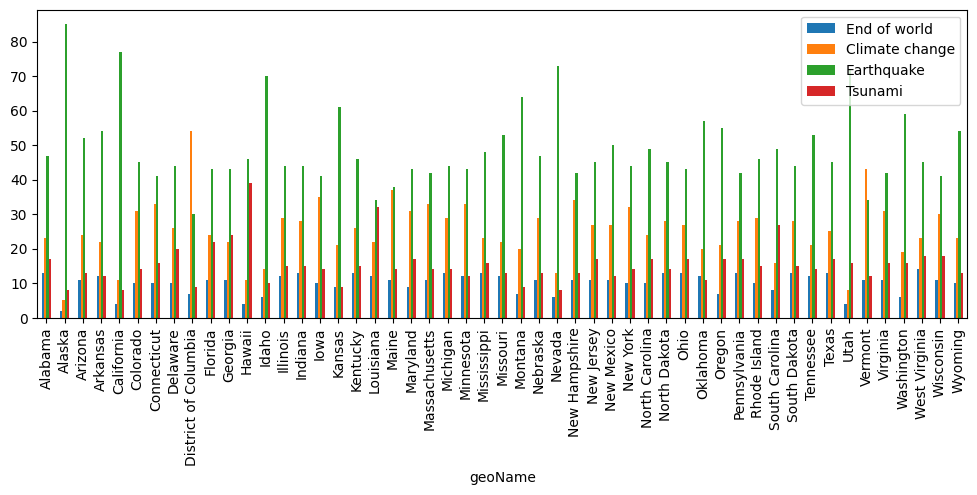

In [23]:
t1.plot(kind='bar',figsize=(12,4))

# Query complejo

In [24]:
dt = TrendReq(hl='es',retries=3, backoff_factor=20)
kw_list = ["Fin mundo","Cambio Climatioc","Terremoto","Tsunami"]
dt.build_payload(kw_list, cat=0, timeframe='today 5-y', geo='AR', gprop='')

In [25]:
dt.interest_by_region()

,Fin mundo,Cambio Climatioc,Terremoto,Tsunami
geoName,,,,
Buenos Aires,32,0,41,27
Catamarca,25,0,60,15
Chaco,37,0,37,26
Chubut,30,0,41,29
Ciudad Autónoma de Buenos Aires,33,0,45,22
Corrientes,39,0,36,25
Córdoba,27,0,52,21
Entre Ríos,35,0,42,23
Formosa,41,0,38,21


In [26]:
u=dt.interest_over_time()
u

,Fin mundo,Cambio Climatioc,Terremoto,Tsunami,isPartial
date,,,,,
2018-05-20,3,0,3,2,False
2018-05-27,2,0,3,2,False
2018-06-03,3,0,4,1,False
2018-06-10,3,0,3,2,False
2018-06-17,5,0,5,2,False
...,...,...,...,...,...
2023-04-09,4,0,3,1,False
2023-04-16,4,0,4,1,False
2023-04-23,4,0,5,1,False


<Axes: xlabel='date'>

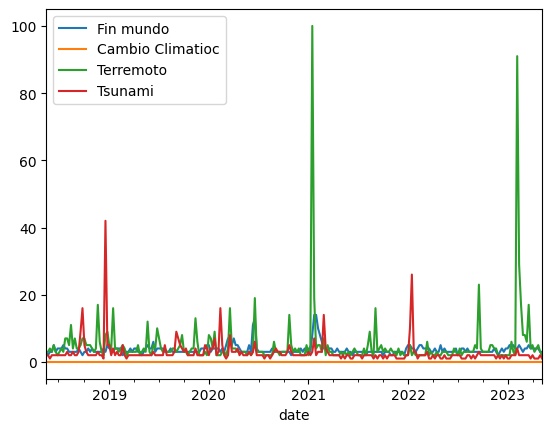

In [27]:
u.plot()